In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from numpy.random import randint,uniform,choice

In [2]:
def Gillespie_Run(rate, Cpars, n0, old_pop, old_n_per_loc, T):
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    is_confined = np.zeros(n_pop,bool)
    is_dead     = np.zeros(n_pop,bool)
    being_tested= np.zeros(n_pop,bool)
    
    # [ S, A, I, R, H ]
    # [ 0, 1, 2, 3, 4 ]
    tests_conducted = 0
    results_declared=0
    locations_moved = 0
    n = np.copy(n0)
    N = np.sum(n)
    
    output = np.append(0,n0)
    
    t=0.0
    t_out = 0
    
    while(t < T):
        
        if(t>=t_out):
            output = np.vstack((output, np.append(t_out,n)))
            t_out+=1
            #print(t_out)
                
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 
        
        a = np.zeros(len(n)+4)

        a[0] =        rate[0][1] * np.sum(n_per_location[:,0]* (Cpars[1]* n_per_location[:,1] + Cpars[2]*n_per_location[:,2] + Cpars[4]*n_per_location[:,4]))/1
        a[1] = a[0] + rate[1][2] * n[1]
        a[2] = a[1] + rate[1][3] * n[1]
        a[3] = a[2] + rate[2][3] * n[2]
        a[4] = a[3] + rate[2][4] * n[2]
        a[5] = a[4] + rate[4][3] * n[4]
        
        a[6]= a[5]+ np.sum(is_not_conf_or_dead)*random_test_rate
        a[7]= a[6]+ np.sum(being_tested)*finish_test_rate 
        a[8]= a[7]+ np.sum(is_not_conf_or_dead*link_weight)
        
        dt = -np.log(np.random.uniform(0.0,1.0)) / a[-1]
        t = t+dt

        p = np.random.uniform(0.0,1.0) * a[-1]

        if(p < a[0]):  # S -> A
            psum = 0
                                                                                                                      
            for i in range(0,n_pop):
                if(pop[i][0]==0):
                    psum += rate[0][1]* (Cpars[1]*n_per_location[pop[i][3] ][1] + Cpars[2] * n_per_location[pop[i][3] ][2] + Cpars[4]*n_per_location[pop[i][3]][4])/1
                    
                    if(psum>p):
                        break
                        
                                                                                                                      
            # Set the individual to asymptomatic
            pop[i][0] = 1
            
            n[0] = n[0] - 1 
            n[1] = n[1] + 1
            
            n_per_location[pop[i][3]][0] -= 1
            n_per_location[pop[i][3]][1] += 1
            
        elif(p < a[1]): # A -> I
            psum = a[0]
            
            for i in range(0,n_pop):
                if(pop[i][0]==1):
                    psum += rate[1][2]
                    
                    if(psum>p):
                        break

            
            # Set the individual to infected
            pop[i][0] = 2
            
            n[1] = n[1] - 1 
            n[2] = n[2] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][2] += 1
            
            
        elif(p < a[2]): # A -> R
            psum = a[1]
            
            for i in range(0,n_pop):
                if(pop[i][0]==1):
                    psum += rate[1][3]
                    
                    if(psum>p):
                        break

            # Set the individual to recovered
            pop[i][0] = 3
            
            n[1] = n[1] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][3] += 1
            
        
        elif(p < a[3]): # I -> R
            psum = a[2]
            
            for i in range(0,n_pop):
                if(pop[i][0]==2):
                    psum += rate[2][3]
                    
                    if(psum>p):
                        break

            
            # Set the individual to recovered
            pop[i][0] = 3
            
            n[2] = n[2] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][3] += 1
            
            
            
        elif(p < a[4]): # I -> H
            psum = a[3]
            
            for i in range(0,n_pop):
                if(pop[i][0]==2):
                    psum += rate[2][4]
                    
                    if(psum>p):
                        break

            # Set the individual to hospitalised
            pop[i][0] = 4
            
            n[2] = n[2] - 1 
            n[4] = n[4] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][4] += 1
            
            
        
        elif(p < a[5]):  # H -> R
            psum = a[4]
            
            for i in range(0,n_pop):
                if(pop[i][0]==4):
                    psum += rate[4][3]
                    
                    if(psum>p):
                        break

            # Set the individual to recovered
            pop[i][0] = 3
            
            n[4] = n[4] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][4] -= 1
            pop[i][3] = pop[i][1]               # Send them home
            n_per_location[pop[i][3]][3] += 1
            
            
            
        elif(p < a[6]):                                     # Conduct a random test
            psum = a[5]
            tests_conducted += 1
            for i in range(0,n_pop):
                if(is_not_conf_or_dead[i]): # If the person isn't confined or dead
                    psum += random_test_rate
                   
                    if(psum>p):
                        break

            being_tested[i]=True

        elif(p < a[7]):
            psum = a[6]
            results_declared +=1
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==1 or pop[i][0]==2 or pop[i][0]==4) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected (or hospitalised) and the test works
                is_confined[i] = True                                # They are confined
                
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = randint(n_hospitals)#pop[i][1]                      # Send them to a hospital at random (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person
        
        
# <-------## TO DO : SET A PROTOCOL IN PLACE FOR TESTING HOSPITALISED PEOPLE ###############
        
        
        
        elif(p < a[8]):                                              # All else failing, move people around
            psum = a[7]
            
            for i in range(0,n_pop):

                if (not is_confined[i] and not is_dead[i]):  # If they aren't confined or dead
                    psum += link_weight[i]                 # move them to their other location

                    if(psum>p):
                        break

            home_loc = pop[i][1]
            net_loc  = pop[i][2]

            if(pop[i][3]==home_loc):                       # If the person is at home
                pop[i][3] = net_loc                        # move them to their network location
                locations_moved += 1
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[home_loc][j] -= 1
                        n_per_location[net_loc][j] += 1     
                
            elif(pop[i][3]==net_loc):
                pop[i][3] = home_loc                       # otherwise move them home
                locations_moved += 1
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[net_loc][j] -= 1
                        n_per_location[home_loc][j] += 1
            else:
                print("Current location neither home nor network!")
        
        else:
            print("(Gillespie) Something went wrong.")
    print("Tests Done in total: "+str(tests_conducted))
    print("Results Given in total: "+str(results_declared))
    print("Locations Moved in total: "+str(locations_moved))
    return output
    

In [3]:
def Tau_Leap(rate, Cpars, n0, old_pop, old_n_per_loc, T):
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
    is_dead     = np.zeros(n_pop,bool)               # Boolean array, is dead? (Initial values, all "no".)
    being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?
    
    tests_conducted = 0
    results_declared=0
    locations_moved = 0
    
    dt = 0.1
    
    n = np.copy(n0)
    N = np.sum(n)

    transitions = np.zeros((n_states,n_states),int)
    
    output = np.append(0,n0)
    
    t=0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],       # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],       # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],       # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],int)  # the change in that particular state, given an event.

    r = np.zeros(n_events)             # Empty array to store rates per event
    K = np.zeros(n_events,int)         # Empty array to store number of events that occur in dt (Poisson distributed)
    
    while(t < T):
        
        for i in range(0, n_loc):                 # Loop over locations
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location

#             if(len(indices)==0):
#                 continue                         # If there's no one in this location, try the next one
    

#             This part can be done more efficiently using a matrix, but that's for later

            r[0] = rate[0][1] * n_per_location[i][0] * (Cpars[1]*n_per_location[i][1] + Cpars[2]*n_per_location[i][2] + Cpars[4]*n_per_location[i][4])/1
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            ##### Adaptive Step Sizes ##########
            
#             eps= 0.4
#             mu = np.dot(v,r)
#             sigsq= np.dot(v**2,r)
#             g  = np.array([2,2,1,1])
            
#             b = np.zeros(n_states)
            
#             for j in range(0,n_states):
#                 b[j] = max(eps * n_per_location[i][j] / g[j], 1)
            
#             b1 = b/np.abs(mu)
#             b2 = b**2/sigsq
            
#             dt = min(b1.any(),b2.any())
            
            ######################################
            
             
            for j in range(0,n_events):
                K[j] = np.random.poisson(r[j]*dt)
            

            n_per_location[i] += np.dot(v,K)            # Change number per location by Sum_j v_ij K_j change
                         
            transitions[0][1] = K[0]
            transitions[1][2] = K[1]
            transitions[1][3] = K[2]
            transitions[2][3] = K[3]
            transitions[2][4] = K[4]
            transitions[4][3] = K[5]
            
            
#             if(np.all(transitions==0)):
#                 continue
            
            done = np.zeros(len(indices),bool)      # Array to make sure same individual isn't shifted more than once


            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            done[m] = True            # Don't repeat this index
                            l += 1
 
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 

        for i in range(0,n_pop):

            if (is_not_conf_or_dead[i]):  # If they aren't confined or dead
                
                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                locations_moved +=1
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location

                        for j in range(0,len(labels)):
                            if(pop[i][0]==j):
                                n_per_location[home_loc][j] -= 1
                                n_per_location[net_loc][j] += 1     

                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home

                        for j in range(0,len(labels)):
                            if(pop[i][0]==j):
                                n_per_location[net_loc][j] -= 1
                                n_per_location[home_loc][j] += 1

                   # If they're in any other location, keep them there.
        
        
        
        a = np.zeros(2)
        a[0]=  0  + np.sum(is_not_conf_or_dead)*random_test_rate
        a[1]= a[0]+ np.sum(being_tested)*finish_test_rate 
        
        p = np.random.uniform(0.0,1.0) * a[-1]
        
        if(p < a[0]):                                     # Conduct a random test
            psum = 0
            tests_conducted +=1
            for i in range(0,n_pop):
                if(is_not_conf_or_dead[i]): # If the person isn't confined or dead
                    psum += random_test_rate
                   
                    if(psum>p):
                        break

            being_tested[i]=True
        
        elif(p < a[1]):
            psum = a[0]
            results_declared += 1
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==1 or pop[i][0]==2) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected and the test works
                is_confined[i] = True                                # They are confined
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = randint(n_hospitals)                    # Send them to a hospital (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person
                
        else:
            print("(Tau) Something went wrong.")
        
        
        n_per_location[n_per_location<0]=0   # Change all negative populations to zeros
        
        t += dt
        output = np.vstack((output, np.append(t,n)))
        #print(t)
    print("Tests Done in total: "+str(tests_conducted))
    print("Results Given in total: "+str(results_declared))
    print("Locations Moved in total: "+str(locations_moved))
    return output
        

In [ ]:
def an_soln(rate,Cpars,n0,T_max):
    
    n = np.copy(n0)
    
    beta = rate[0][1]
    alpha_lambdaP = rate[1][2]
    one_minus_alpha_lambdaP = rate[1][3]
    deltaS = rate[2][3]
     
    N = np.sum(n0)
    t = np.linspace(0, T_max, T_max)# A grid of time points (in days)
    
    #########################################

    # The differential equations ############
    
    def deriv(y, t):
        [S, P, I, R] = y
        dSdt = - beta * S * (Cpars[1]*P + Cpars[2]*I)/N
        dPdt = + beta * S * (Cpars[1]*P + Cpars[2]*I)/N - (alpha_lambdaP + one_minus_alpha_lambdaP) * P
        dIdt = + alpha_lambdaP * P - deltaS * I
        dRdt = + one_minus_alpha_lambdaP * P + deltaS * I

        return dSdt, dPdt, dIdt, dRdt
    
    #########################################
    
    y0 = n                              # Initial conditions vector
    
    ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
    S, P, I, R = ret.T                                   # Return the transpose of the matrix

    return t, S, P, I, R

In [9]:
n_pop = 10000
n_loc = 2750
n_net = 250
n_overlap = 1
n_hospitals = 10 # Set the number of hospitals.

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________


labels = [0,1,2,3,4]      # Number of states a person can be in, [S,A,I,R,H] (Not very important, just for bookkeeping)

person_attr = 4           # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)
n_events = 6              # Different events in the model (currently) S->A, A->I, A->R, I->R, I->H, H->R
    

tf = 40#100

rate_array = np.zeros((n_states,n_states))

rate_array[0][1] = 0.2  # S -> A
rate_array[1][2] = 0.5  # A -> I
rate_array[1][3] = 0.1  # A -> R
rate_array[2][3] = 0.1  # I -> R
rate_array[2][4] = 0.25 # I -> H
rate_array[4][3] = 0.1  # H -> R


Cpars = [0,1,1,0,1]

random_test_rate =0
test_sensitivity =0.99
finish_test_rate =24.0

In [5]:
## CREATE POPULATION #####

def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
is_dead     = np.zeros(n_pop,bool)               # Boolean array, is dead? (Initial values, all "no".)
being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?

n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks

# Initial populations ###########

n_pre = 10


n = np.array([n_pop-n_pre, n_pre, 0, 0, 0],int)
             # [ S         , P,   I, R, H ]

old_n = np.copy(n)

##################################


for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)               # Assign random homes for remainder with random network
    pop[i] = create_person(0,home)

    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 1#0.1                           # This number must be between 0 and 1 (probability of shifting along link)

r = choice(n_pop,size=n_pre,replace=False)         # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

old_n_per_location = np.copy(n_per_location)
old_pop = np.copy(pop)

In [6]:
n_iter = 1

# s = time.time()
tl_plot1 = Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

# for i in range(0,n_iter-1):
#     tl_plot1 = tl_plot1 + Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

# tl_plot1 = tl_plot1/n_iter
# e = time.time()
# print("Tau Leap1 took "+str(e-s))

# np.savetxt("./Comparing C and Python Results/tau_mc_SAIRH.txt",tl_plot1,delimiter=" ")

# s = time.time()
g_plots = Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# for i in range(0,n_iter-1):
#     g_plots = g_plots + Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# g_plots = g_plots/n_iter

# e = time.time()

# np.savetxt("./Comparing C and Python Results/GA_SAIRH.txt",g_plots,delimiter=" ")

# print("Gillespie took "+str(e-s))

# np.savetxt("./Comparing C and Python Results/GA_SAIRH.txt",g_plots,delimiter=" ")

Tests Done in total: 309
Results Given in total: 91
Locations Moved in total: 3998070
Tests Done in total: 198887
Results Given in total: 190811
Locations Moved in total: 198506


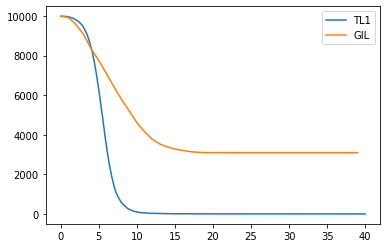

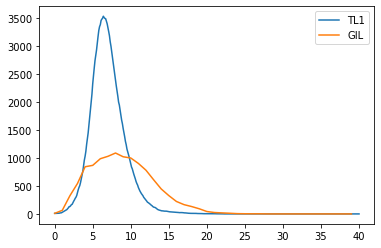

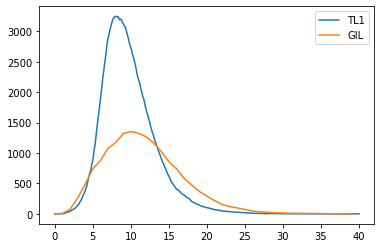

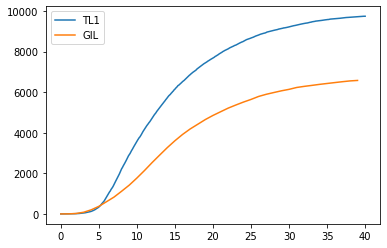

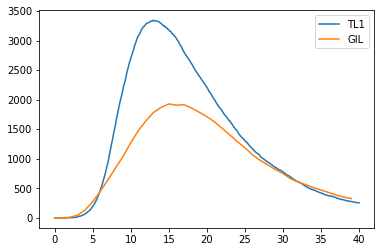

In [7]:
for i in range(1,6):
    plt.plot(tl_plot1[:,0],tl_plot1[:,i],label="TL1")
    plt.plot(g_plots[:,0],g_plots[:,i],label="GIL")
    plt.legend()
    plt.show()


In [10]:
tl_plot2 = Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)
g_plots2 = Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went

(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went wrong.
(Tau) Something went

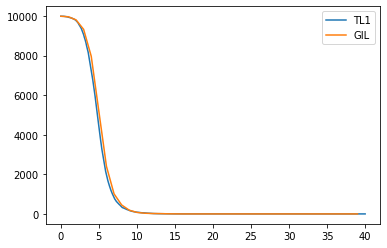

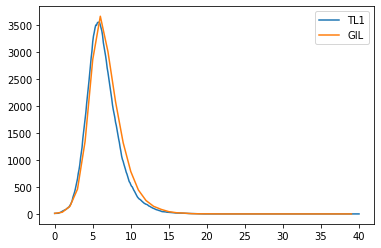

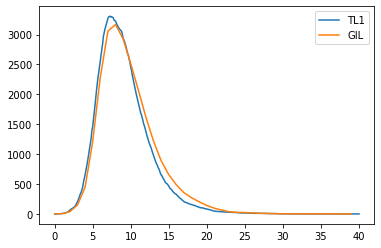

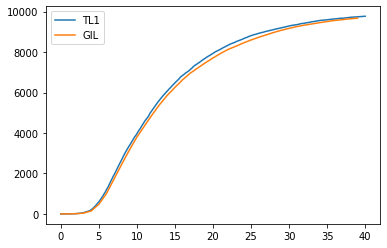

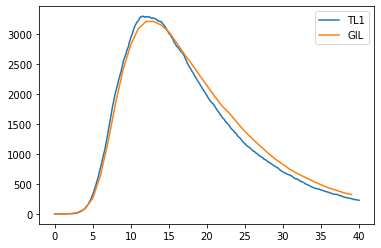

In [11]:
for i in range(1,6):
    plt.plot(tl_plot2[:,0],tl_plot2[:,i],label="TL1")
    plt.plot(g_plots2[:,0],g_plots2[:,i],label="GIL")
    plt.legend()
    plt.show()


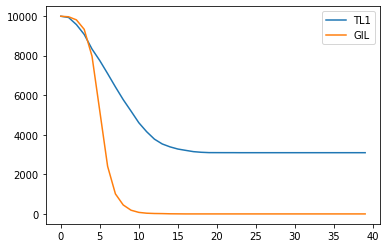

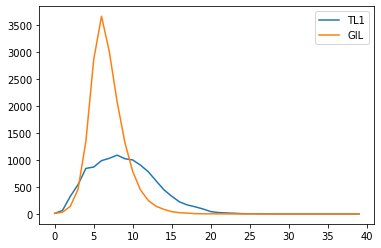

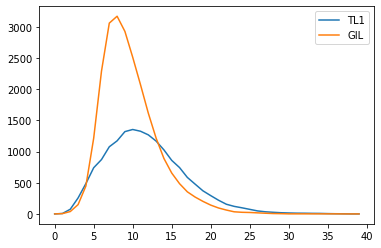

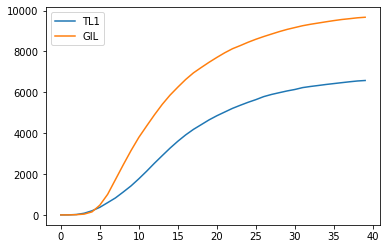

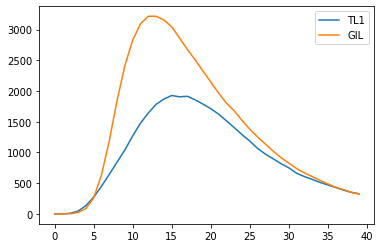

In [12]:
for i in range(1,6):
    plt.plot(g_plots[:,0],g_plots[:,i],label="TL1")
    plt.plot(g_plots2[:,0],g_plots2[:,i],label="GIL")
    plt.legend()
    plt.show()